In [1]:
import sys
import miner2 
import miner2.preprocess
import miner2.mechanistic_inference
import pandas as pd
import os
import scanpy as sc
import numpy
import matplotlib.pyplot as plt
import dill
import pickle
import seaborn as sb

%matplotlib inline

tf_2_genes_path = './miner2-master/miner2/data/tfbsdb_tf_to_genes.pkl' # location of tfbs_db

2019-08-15 11:03:11 	 hello from miner2 version 0.0.9


In [2]:
def get_gene_set():
    # get all unique gene Ensembl ids from tfbsdb database
    with open(tf_2_genes_path, 'rb') as f:
        tf_2_genes = pickle.load(f)
    
    gene_set = set()
    for key in tf_2_genes:
        value = tf_2_genes[key]
        gene_set.add(key)
        gene_set.update(value)
    return gene_set

def get_ensembl_protein_coding_genes():
    ensembl_df = pd.read_csv('/home/aliu/Projects/causalAssociation/src/mart_export.txt', sep=',', header = 0, index_col = None, engine='python')
    return set(ensembl_df['Gene name']), set(ensembl_df['Gene stable ID'])

def cmp_to_key(mycmp):
    'Convert a cmp= function into a key= function'
    class K:
        def __init__(self, obj, *args):
            self.obj = obj
        def __lt__(self, other):
            return mycmp(self.obj, other.obj) < 0
        def __gt__(self, other):
            return mycmp(self.obj, other.obj) > 0
        def __eq__(self, other):
            return mycmp(self.obj, other.obj) == 0
        def __le__(self, other):
            return mycmp(self.obj, other.obj) <= 0
        def __ge__(self, other):
            return mycmp(self.obj, other.obj) >= 0
        def __ne__(self, other):
            return mycmp(self.obj, other.obj) != 0
    return K

def comparator(x, y):
    if (x[1][0] != y[1][0]):
        return x[1][0] - y[1][0]
    return x[1][1] - y[1][1]

def select_ensembl_id(gene_ids):
    # select single ensembl_id from list of ensembl_ids
    for gene_id in gene_ids:
        if gene_id not in ensembl_id_set or gene_id not in gene_set:
            gene_ids.remove(gene_id)
            
    if len(gene_ids) == 0:
        return None
    elif len(gene_ids) == 1:
        return gene_ids[0]
            
    with open(tf_2_genes_path, 'rb') as f:
        tf_2_genes = pickle.load(f)
    
    tracker = {} # count number of times gene id is tf or affected by tf
    for gene_id in gene_ids:
        tracker[gene_id] = [0,0] #[tf, affected by tf]
    for key in tf_2_genes:
        if key in tracker:
            tracker[gene_id][0] += 1
        for affected_gene in tf_2_genes[key]:
            if affected_gene in tracker:
                tracker[affected_gene][1] += 1
    
    # return most active gene id in tfbsdb
    sorted_genes = sorted(tracker.items(), key=cmp_to_key(comparator)) 
    # print(sorted_genes)

    return sorted_genes[-1][0]
    
gene_set = get_gene_set()
gene_name_set, ensembl_id_set = get_ensembl_protein_coding_genes()

In [3]:
# read file from adata
aData = sc.read_h5ad('./write/pbmc3k.h5ad')

# construct dataframe and add index/column names
df = pd.DataFrame(aData.X)
df.index = aData.obs.index
df.columns = aData.var.index
del df.columns.name
del df.index.name

df = df.T

# convert gene symbol to ensembl id
selected_genes = []
new_genes_index = []   
### use https://biodbnet-abcc.ncifcrf.gov/db/db2db.php to get ensembl gene id for gene symbol
df_gene_conversion = pd.read_csv('/home/aliu/Projects/causalAssociation/src/gene_symbol_to_ensembl.txt', sep='\t', header = 0, index_col = 0, engine='python')

for gene in df.index:
    ensembl_id = df_gene_conversion.loc[gene]['Ensembl Gene ID']
    if ensembl_id == '-' or gene not in gene_name_set:
        continue
    if ";" in ensembl_id:
        ensembl_id_list = ensembl_id.split('; ')
        ensembl_id = select_ensembl_id(ensembl_id_list)
    if ensembl_id == None:
        continue
    selected_genes.append(gene)
    new_genes_index.append(ensembl_id)

In [4]:
# gene symbol to ensembl id mapping
gs_to_ensembl = pd.DataFrame(data = {'Gene Symbol': selected_genes, 'Ensembl Id': new_genes_index})
gs_to_ensembl = gs_to_ensembl.set_index('Gene Symbol')

# manually fix duplicate ensembl id
gs_to_ensembl.at['HIST1H2AL','Ensembl Id'] = 'ENSG00000276903'
gs_to_ensembl.at['HIST1H2AM','Ensembl Id'] = 'ENSG00000278677'

df = df.reindex(gs_to_ensembl.index)
df.index = gs_to_ensembl['Ensembl Id']
df

,AML707B-D97_AAAAGGCTGAGA,AML707B-D97_AACTTTGTGCCG,AML707B-D97_AATTGAGTGCTN,AML707B-D97_ACACTTGACTAA,AML707B-D97_ACCCGCGAAGAC,AML707B-D97_ACCGTCTTTGAC,AML707B-D97_ACTATTCAACGG,AML707B-D97_ACTTAGTCGGTC,AML707B-D97_AGAGATTGACAG,AML707B-D97_AGAGTTATCTCA,...,AML707B-D97_TTGCGTATAGCC,AML707B-D97_TTGTGTGACTGN,AML707B-D97_AACCAACTGACC,AML707B-D97_GATTTATATTGC,AML707B-D97_GTAATGGCGGAT,AML707B-D97_CACGATGGGTTG,AML707B-D97_CGCCCGTAGGTG,AML707B-D97_GTTGAACCGGAN,AML707B-D97_CGGCAACATCGN,AML707B-D97_GGCTCAATAATA
Ensembl Id,,,,,,,,,,,,,,,,,,,,,
ENSG00000121410,-0.245606,3.646831,-0.180156,0.113208,-0.095771,-0.243369,-0.150956,-0.267769,-0.247083,-0.328503,...,-0.293082,4.558834,-0.250088,-0.260132,-0.281522,-0.085065,-0.267904,-0.206207,-0.343119,-0.305952
ENSG00000090861,-0.107484,-0.230618,-0.152403,-0.484422,-0.234129,-0.247508,-0.210021,-0.181478,-0.138622,-0.248569,...,-0.097665,-0.191706,-0.251415,-0.259318,-0.122401,-0.280208,-0.084651,-0.035407,-0.277565,-0.132438
ENSG00000124608,-0.377974,-0.252265,-0.279469,-0.410200,-0.267487,0.069948,-0.317054,-0.071464,-0.449096,-0.416021,...,-0.153845,-0.263817,-0.009088,-0.553043,-0.291729,-0.357710,-0.178179,-0.006864,-0.422594,-0.225618
ENSG00000266967,0.148152,-0.263063,-0.085037,-0.430711,-0.240919,5.943531,-0.121587,-0.471511,0.209772,-0.032172,...,-0.197245,-0.180545,-0.690206,0.171927,-0.016936,-0.173600,-0.135338,-0.326015,-0.071178,-0.141035
ENSG00000157426,0.016221,-0.202265,-0.056123,0.057246,-0.059340,-0.531027,3.677901,-0.361542,0.056535,-0.144300,...,-0.234372,-0.235856,-0.464728,0.041230,-0.112476,-0.002181,-0.176638,-0.241972,-0.176248,-0.207068
ENSG00000149313,-0.271511,-0.115301,-0.438974,-0.747050,-0.570445,-0.179869,-0.415788,-0.171008,-0.184276,0.273820,...,3.572078,0.094221,-0.122654,0.117222,-0.156497,-0.489054,-0.310806,-0.664744,0.377497,-0.081101
ENSG00000135776,-0.243620,-0.133454,-0.357153,-0.140631,-0.362303,-0.363448,-0.269097,-0.324907,-0.123105,0.196380,...,-0.367625,-0.049085,-0.277893,0.212278,-0.225632,-0.219139,-0.415411,2.901437,0.281530,-0.219871
ENSG00000131269,-0.253420,-0.139152,-0.409695,-0.781595,-0.548524,-0.182969,-0.406454,-0.165551,-0.187691,0.195099,...,-0.185274,0.058178,-0.137316,0.044138,-0.149454,-0.493108,-0.271046,-0.565014,0.279829,-0.080820
ENSG00000124574,-0.158640,-0.157767,-0.158914,-0.294771,-0.185885,-0.097300,-0.181633,-0.108641,-0.177800,-0.177122,...,-0.105163,-0.138450,-0.112185,-0.217466,-0.138382,-0.213549,-0.111891,-0.080421,-0.181097,7.838297


In [5]:
def entropy(values, minval, maxval):
    # calc entropy
    data = numpy.array(values)
    hist = numpy.histogram(data, bins=50, range=(minval, maxval))[0]
    length = len(hist)

    if length <= 1:
        return 0

    counts = numpy.bincount(hist)
    probs = [float(i) / length for i in counts]
    n_classes = numpy.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    ent = 0.

    # Compute standard entropy.
    for i in probs:
        if i > 0:
            ent -= float(i) * numpy.log(i)
    return ent
    
    
def get_most_variable_genes(df, n=50):
    # get genes with most entropy
    minval = min(df.values.flatten())
    maxval = max(df.values.flatten())
    gene_entropy = []
    # for each gene, append(gene, entropy(gene)) to list
    for gene in df.index:
        ent = entropy(df.loc[gene].values, minval, maxval)
        gene_entropy.append((gene, ent))
    
    sorted_entropy = sorted(gene_entropy, key=lambda x: x[1])
    # get highest entropy genes from lowest to highest
    sorted_entropy = sorted_entropy[-1:-n:-1]
    variable_genes = [x[0] for x in sorted_entropy]
    return variable_genes

def generate_heatmap(df, title, savefig = False):
    heat_map = sb.heatmap(df)
    heat_map.set_title(title)
    plt.tight_layout()
    plt.show()
    
    if savefig:
        heat_map.get_figure().savefig(results_dir + title)


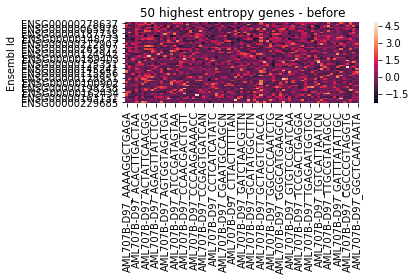

In [6]:
# get 50 most variable genes (by entropy) by highest to lowest
most_variable_genes = get_most_variable_genes(df)

generate_heatmap(df.loc[most_variable_genes], "50 highest entropy genes - before", savefig=False)

In [7]:
results_dir='./results/GSM3587977_AML707B/'

num_cores = 4          # required for coexpression
min_number_genes = 6   # required for coexpression
min_correlation = 0.05  # required for mechanistic inference. Bulk RNAseq default=0.2;single cell RNAseq default=0.05

if os.path.exists(results_dir) == False:
    os.mkdir(results_dir)
    os.mkdir(results_dir+'figures')
    os.mkdir(results_dir+'info')


In [8]:
# preprocess data
expression_data, conversion_table = miner2.preprocess.main(df)
expression_data.shape

(1782, 73)

ENSG00000206308
ENSG00000229685


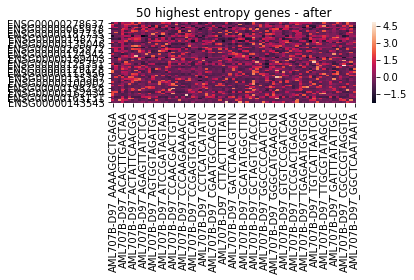

In [9]:
for i in most_variable_genes:
    if i not in expression_data.index:
        print(i)

# get 50 most variable genes (by entropy) by highest to lowest
generate_heatmap(expression_data.loc[get_most_variable_genes(expression_data)], "50 highest entropy genes - after", savefig=False)

In [11]:
# post processed data plots
individual_expression_data = [expression_data.iloc[:,i] for i in range(50)]
plt.boxplot(individual_expression_data)
plt.title("Sample expression profiles")
plt.ylabel("Relative expression")
plt.xlabel("Sample ID")
plt.xticks(fontsize=6)

figure_name=results_dir+'figures/boxplots.pdf'
plt.tight_layout()
plt.savefig(figure_name)
plt.clf()

plt.hist(expression_data.iloc[0,:],bins=100,alpha=0.75)
plt.title("Expression of single gene")
plt.ylabel("Frequency")
plt.xlabel("Relative expression")

figure_name=results_dir+'figures/singleGene.pdf'
plt.tight_layout()
plt.savefig(figure_name)
plt.clf()

plt.hist(expression_data.iloc[:,0],bins=200,color=[0,0.4,0.8],alpha=0.75)
plt.ylim(0,350)
plt.title("Expression of single sample",FontSize=14)
plt.ylabel("Frequency")
plt.xlabel("Relative expression")

figure_name=results_dir+'figures/singleSample.pdf'
plt.tight_layout()
plt.savefig(figure_name)
plt.clf()


<Figure size 432x288 with 0 Axes>

In [12]:
# STEP 1: clustering
initial_clusters = miner2.coexpression.cluster(expression_data,min_number_genes=min_number_genes,num_cores=num_cores)
revised_clusters = miner2.coexpression.revise_initial_clusters(initial_clusters,expression_data)

2019-08-15 11:05:27 	 coexpression
2019-08-15 11:05:27 	 working on coexpression step 1 out of 5
2019-08-15 11:05:29 	 working on coexpression step 2 out of 5
2019-08-15 11:05:30 	 working on coexpression step 3 out of 5
2019-08-15 11:05:30 	 working on coexpression step 4 out of 5
2019-08-15 11:05:31 	 working on coexpression step 5 out of 5
2019-08-15 11:05:31 	 genes clustered: 1327
2019-08-15 11:05:31 	 revising initial clusters
2019-08-15 11:05:32 	 revision completed
2019-08-15 11:05:32 	 genes clustered: 1327
2019-08-15 11:05:32 	 unique clusters: 115


In [14]:
# QC: visualize coexpression clusters

# retrieve first 10 clusters for visual inspection
first_clusters = numpy.hstack([revised_clusters[i] for i in numpy.arange(10).astype(str)])
# visualize first 10 clusters
plt.imshow(expression_data.loc[first_clusters,:],aspect="auto",cmap="viridis",vmin=-1,vmax=1)
plt.grid(False)
plt.ylabel("Genes")
plt.xlabel("Samples")
plt.title("First 10 coexpression clusters")
figure_name=results_dir+'figures/first.coexpression.clusters.pdf'
plt.tight_layout()
plt.savefig(figure_name)
plt.clf()
# visualize 10 random clusters
plt.imshow(expression_data.loc[numpy.random.choice(expression_data.index,len(first_clusters),replace=False),:],aspect="auto",cmap="viridis",vmin=-1,vmax=1)
plt.grid(False)
plt.ylabel("Genes")
plt.xlabel("Samples")
plt.title("Random coexpression genes")
figure_name=results_dir+'figures/random.coexpression.clusters.pdf'
plt.tight_layout()
plt.savefig(figure_name)
plt.clf()

<Figure size 432x288 with 0 Axes>

In [15]:
# STEP 2: mechanistic inference
dill.dump_session(results_dir+'info/bottle.dill')
dill.load_session(results_dir+'info/bottle.dill')

# get first principal component axes of clusters
axes = miner2.mechanistic_inference.get_principal_df(revised_clusters,expression_data,subkey=None,min_number_genes=1)

# analyze revised clusters for enrichment in relational database 
mechanistic_output = miner2.mechanistic_inference.enrichment(axes,revised_clusters,expression_data,p=0.05,
                                                             correlation_threshold=min_correlation,num_cores=num_cores, single_cell = True)

2019-08-15 11:05:59 	 preparing mechanistic inference
2019-08-15 11:05:59 	 mechanistic inference
completed


In [16]:
revised_clusters

{'0': ['ENSG00000023572',
  'ENSG00000049541',
  'ENSG00000050426',
  'ENSG00000059588',
  'ENSG00000066926',
  'ENSG00000069956',
  'ENSG00000070770',
  'ENSG00000087263',
  'ENSG00000090013',
  'ENSG00000095485',
  'ENSG00000100368',
  'ENSG00000107862',
  'ENSG00000110400',
  'ENSG00000111726',
  'ENSG00000116717',
  'ENSG00000120685',
  'ENSG00000121211',
  'ENSG00000122882',
  'ENSG00000123131',
  'ENSG00000123739',
  'ENSG00000125445',
  'ENSG00000125656',
  'ENSG00000134077',
  'ENSG00000135451',
  'ENSG00000135838',
  'ENSG00000137547',
  'ENSG00000143751',
  'ENSG00000147324',
  'ENSG00000156873',
  'ENSG00000156876',
  'ENSG00000164292',
  'ENSG00000164300',
  'ENSG00000168393',
  'ENSG00000173163',
  'ENSG00000173207',
  'ENSG00000173875',
  'ENSG00000177842',
  'ENSG00000178295',
  'ENSG00000184357',
  'ENSG00000186998',
  'ENSG00000189091',
  'ENSG00000213281',
  'ENSG00000214517',
  'ENSG00000215421',
  'ENSG00000233561',
  'ENSG00000250361'],
 '1': ['ENSG00000004864',
  

In [17]:
mechanistic_output

{'0': {'ENSG00000139083': [0.026493925033331853,
   ['ENSG00000100368',
    'ENSG00000122882',
    'ENSG00000164292',
    'ENSG00000156873',
    'ENSG00000023572',
    'ENSG00000178295',
    'ENSG00000134077',
    'ENSG00000173207',
    'ENSG00000049541',
    'ENSG00000164300',
    'ENSG00000173875',
    'ENSG00000143751',
    'ENSG00000214517',
    'ENSG00000189091']]},
 '1': {'ENSG00000186130': [0.0381057676779756,
   ['ENSG00000156172',
    'ENSG00000184508',
    'ENSG00000180096',
    'ENSG00000167797']]},
 '2': {'ENSG00000134954': [0.006353397294960249,
   ['ENSG00000166140',
    'ENSG00000281601',
    'ENSG00000100485',
    'ENSG00000126522',
    'ENSG00000257594',
    'ENSG00000158545',
    'ENSG00000140564',
    'ENSG00000176095',
    'ENSG00000116698',
    'ENSG00000074696',
    'ENSG00000117395',
    'ENSG00000132294',
    'ENSG00000105722',
    'ENSG00000182606',
    'ENSG00000198825',
    'ENSG00000130338',
    'ENSG00000136807',
    'ENSG00000079974',
    'ENSG00000040487'